In [8]:
import os
import json

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

data_dir = '/opt/ml/input/data/ICDAR19'

In [11]:
train_json = json.load(open(os.path.join(data_dir,'json','ICDAR19.json')))

In [15]:
img_names = list(train_json['images'].keys())[5000-4:6000-3]
img_names

['tr_img_05001.jpg',
 'tr_img_05002.jpg',
 'tr_img_05003.jpg',
 'tr_img_05004.jpg',
 'tr_img_05005.jpg',
 'tr_img_05006.jpg',
 'tr_img_05007.jpg',
 'tr_img_05008.jpg',
 'tr_img_05009.jpg',
 'tr_img_05010.jpg',
 'tr_img_05011.jpg',
 'tr_img_05012.jpg',
 'tr_img_05013.jpg',
 'tr_img_05014.jpg',
 'tr_img_05015.jpg',
 'tr_img_05016.jpg',
 'tr_img_05017.jpg',
 'tr_img_05018.jpg',
 'tr_img_05019.jpg',
 'tr_img_05020.jpg',
 'tr_img_05021.jpg',
 'tr_img_05022.jpg',
 'tr_img_05023.jpg',
 'tr_img_05024.jpg',
 'tr_img_05025.jpg',
 'tr_img_05026.jpg',
 'tr_img_05027.jpg',
 'tr_img_05028.jpg',
 'tr_img_05029.jpg',
 'tr_img_05030.jpg',
 'tr_img_05031.jpg',
 'tr_img_05032.jpg',
 'tr_img_05033.jpg',
 'tr_img_05034.jpg',
 'tr_img_05035.jpg',
 'tr_img_05036.jpg',
 'tr_img_05037.jpg',
 'tr_img_05038.jpg',
 'tr_img_05039.jpg',
 'tr_img_05040.jpg',
 'tr_img_05041.jpg',
 'tr_img_05042.jpg',
 'tr_img_05043.jpg',
 'tr_img_05044.jpg',
 'tr_img_05045.jpg',
 'tr_img_05046.jpg',
 'tr_img_05047.jpg',
 'tr_img_0504

In [16]:
img_names = list(train_json['images'].keys())[5000-4:6000-3]
pred_color = (0,0,255)
gt_color = (0,122,122)

cands = defaultdict(set)

for i,img_name in tqdm(enumerate(img_names)):
    img = cv2.imread(os.path.join(data_dir,'images',img_name))

    for key, value in train_json['images'][img_name]['words'].items():
        points = [[int(p[0]),int(p[1])] for p in value['points']]
        x0,y0 = points[0]
        x1,y1 = points[1]
        x2,y2 = points[2]
        x3,y3 = points[3]

        hor = ((x0-x3)**2 + (y0-y3)**2) <= ((x0-x1)**2 + (y0-y1)**2)
        ver = ((x0-x3)**2 + (y0-y3)**2) > ((x0-x1)**2 + (y0-y1)**2)
        ratio = ((x0-x3)**2 + (y0-y3)**2) / ((x0-x1)**2 + (y0-y1)**2 + 1e-3) # ratio > 1: ver, ratio < 1: hor
        
        fourth = x0<x2 and y0<y2 # 시계방향으로 90도 이하로 돌아간 경우 -> 일반적인 경우(거의 대부분 여기 속함)
        first = x0<x2 and y0>y2 # 반시계방향으로 90-180 정도 돌아간 경우 -> 오른쪽으로 갈수록 심하게 올라가는 글씨

        third = x0>x2 and y0<y2 # 시계방향으로 90-180 정도 돌아간 경우 -> 뒤집혀서 오른쪽으로 갈수록 올라가는 글씨 -> 글자가 안돌아가 있으면 말도 안되게 작은 글씨들이나 순서 잘못 찍힌 Polygon인듯
        second = x0>x2 and y0>y2 # 반시계 방향으로 90 이하로 돌아간 경우 -> 뒤집혀서 오른쪽으로 갈수록 내려가는 글씨(없음)

        if first:
            cands['first'].add(img_name)
        elif second:
            cands['second'].add(img_name)
        elif third:
            cands['third'].add(img_name)
        elif fourth:
            cands['fourth'].add(img_name)

        if ratio > 3:
            cands['vertical'].add(img_name)


#print(cands)

1001it [01:17, 12.98it/s]


In [17]:
for k,v in cands.items():
    print(k,len(v))

fourth 959
vertical 480
second 54
first 165
third 178


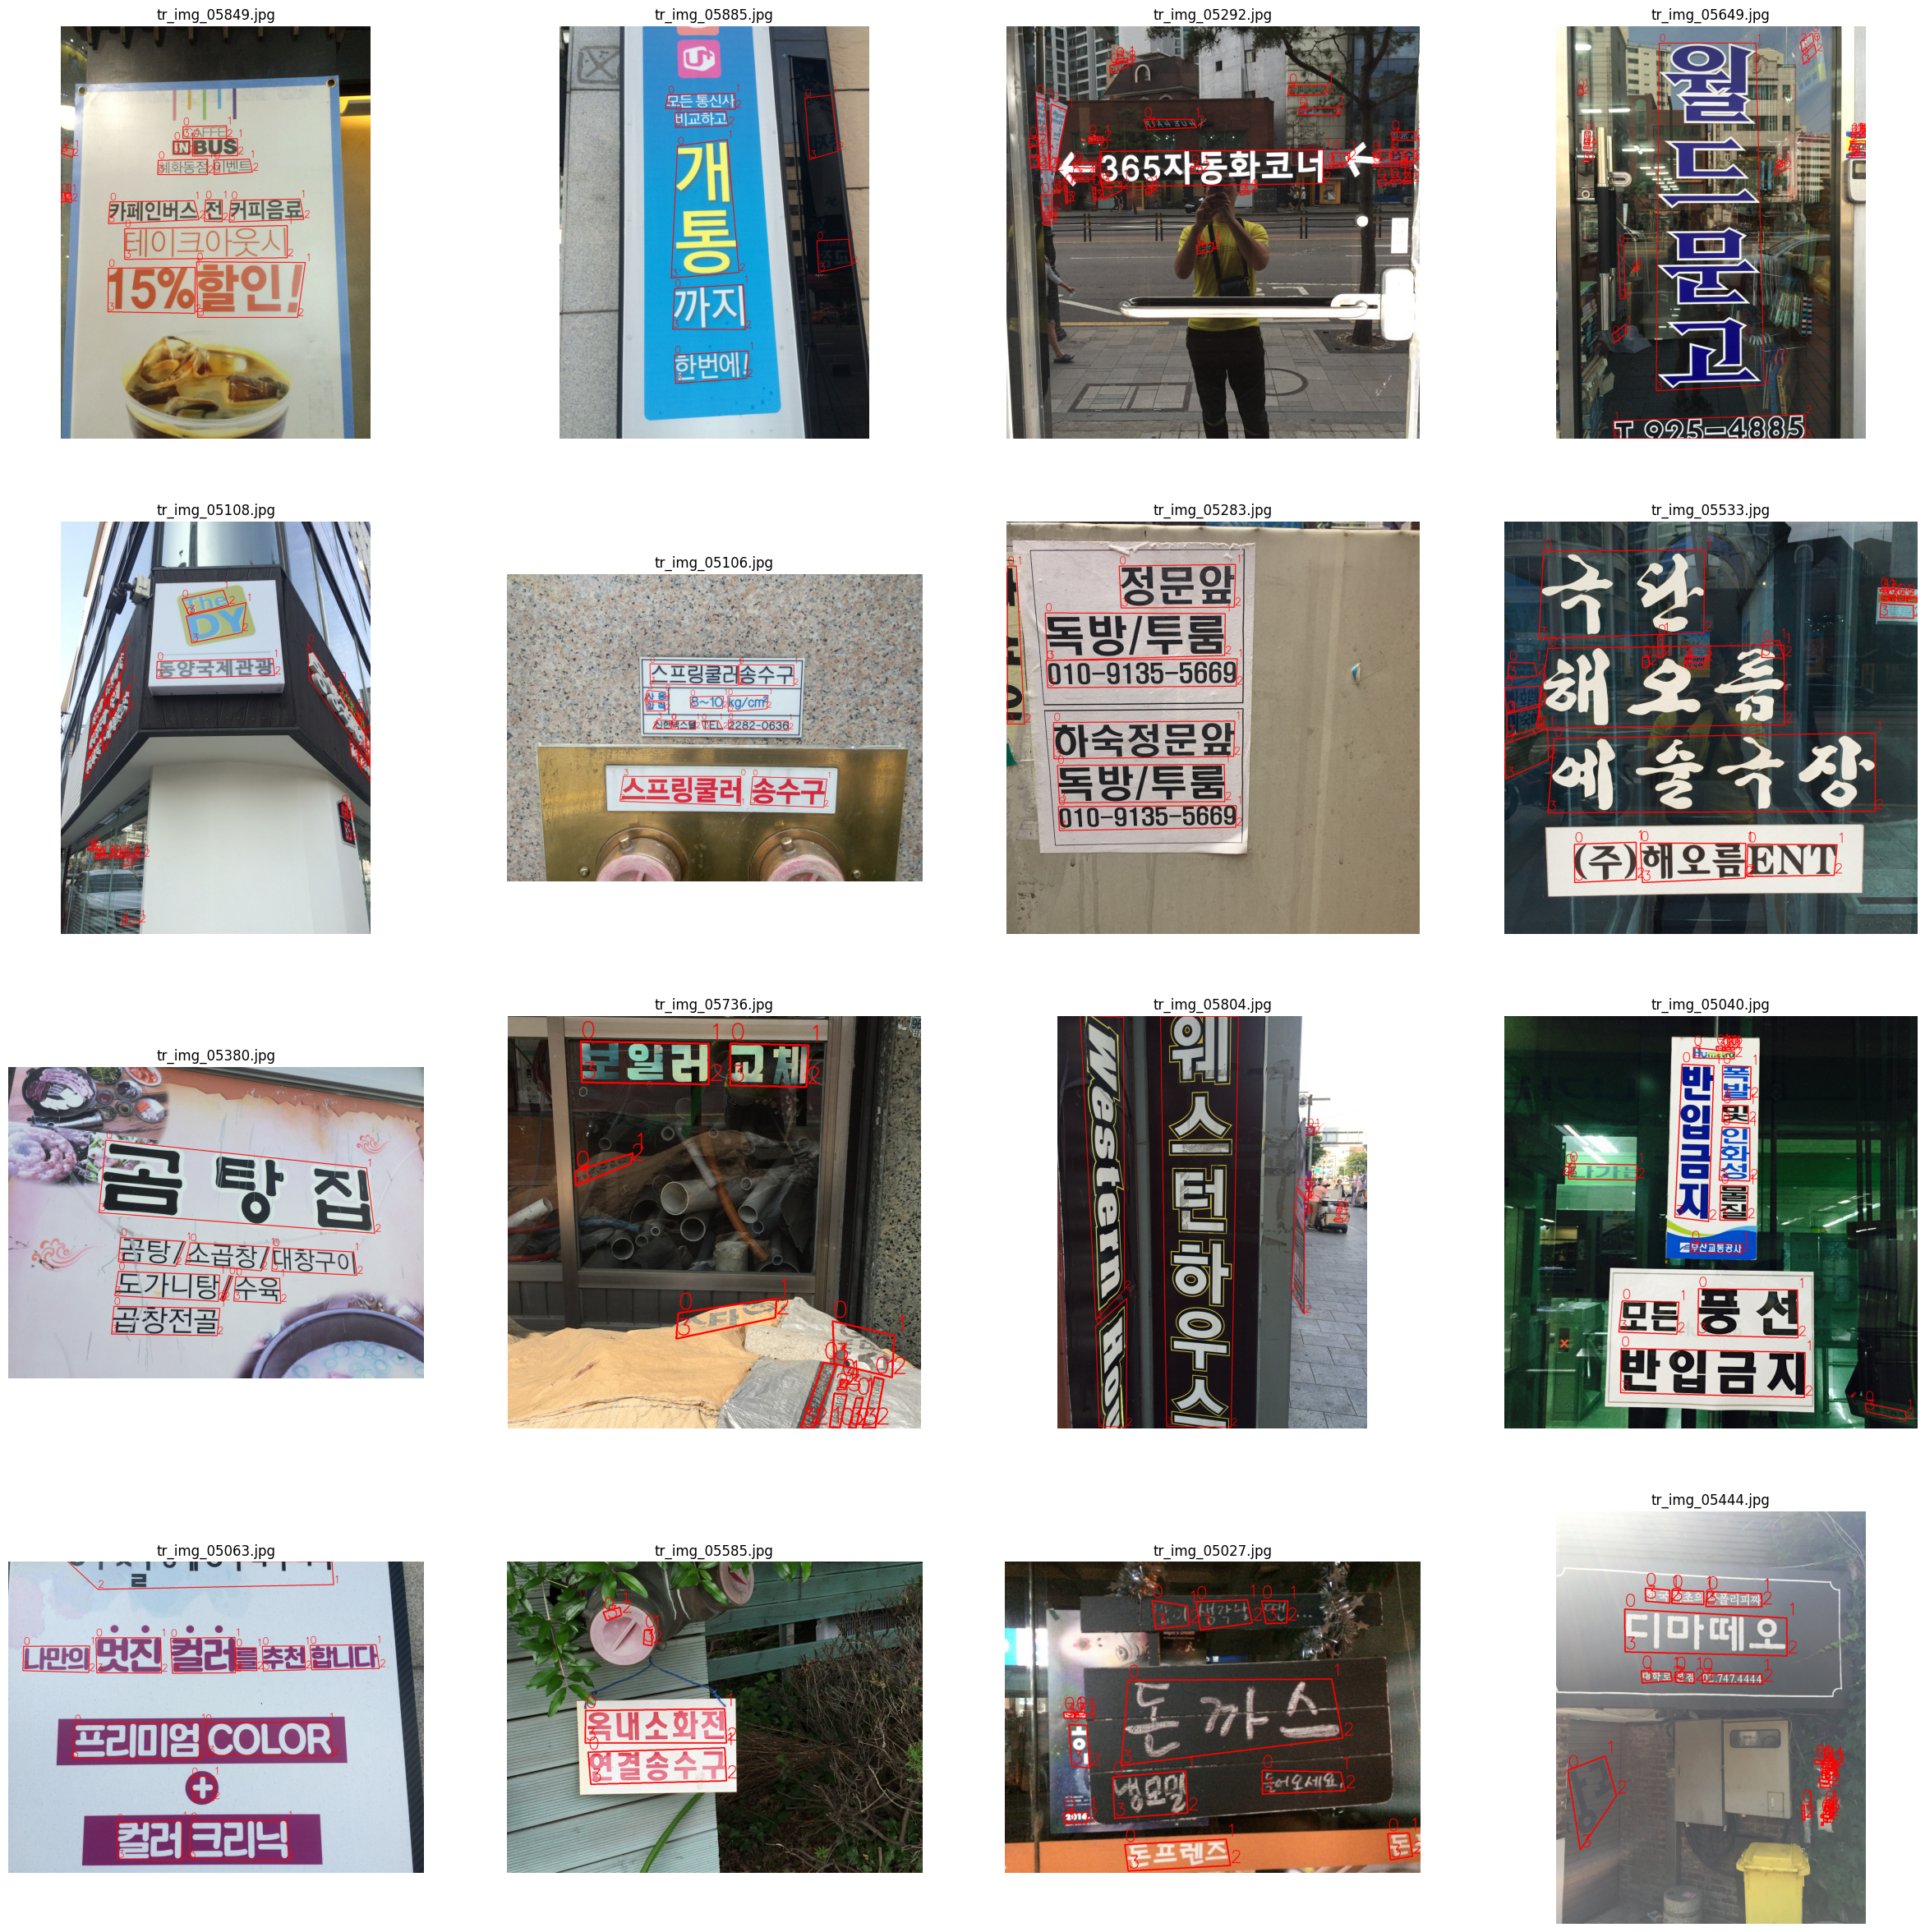

In [19]:
img_names = list(cands['vertical'])[:16]

pred_color = (0,0,255)
gt_color = (0,122,122)

fig, axes = plt.subplots(4,4,figsize=(30,30))

for i,img_name in enumerate(img_names):
    img = cv2.imread(os.path.join(data_dir,'images',img_name))

    for key, value in train_json['images'][img_name]['words'].items():
        points = np.array([[int(p[0]),int(p[1])] for p in value['points']])
        language = value['language']

        img = cv2.polylines(img, [points], True, pred_color, 3)
        cv2.putText(img,"0",(points[0][0],points[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
        cv2.putText(img,"1",(points[1][0],points[1][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
        cv2.putText(img,"2",(points[2][0],points[2][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
        cv2.putText(img,"3",(points[3][0],points[3][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)

    
    axes[i//4,i%4].set_title(img_name)
    axes[i//4,i%4].plot()
    axes[i//4,i%4].imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    axes[i//4,i%4].axis('off')


In [ ]:
not_ver = []